<a href="https://colab.research.google.com/github/nedokormysh/GB_PyTorch/blob/lesson8/GB_PyTorch_hw_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание
Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [332]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from IPython import display

In [333]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Создадим датасет

In [334]:
batch_size = 20

class FunctionDataWrap(torch.utils.data.Dataset):
    def __init__(self, x, y, train=True):
          self.data = x
          self.values = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.values[index]

Создадим функцию формирования точек и построим график

In [335]:
def form(n: int, visual: bool):
  n_points = n

  x = np.linspace(-50, 50, n_points)
  y = (np.sin(x) / x) - (x / 10)
  
  if visual == True:
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, c='r')
    plt.scatter(x, y, label='Сформированнные точки', c='g')
    plt.title('График зависимости у от значений x')
    plt.legend()
    plt.grid()

  dataset = FunctionDataWrap(x, y)

  dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         num_workers=2)

  return x, y, dataloader

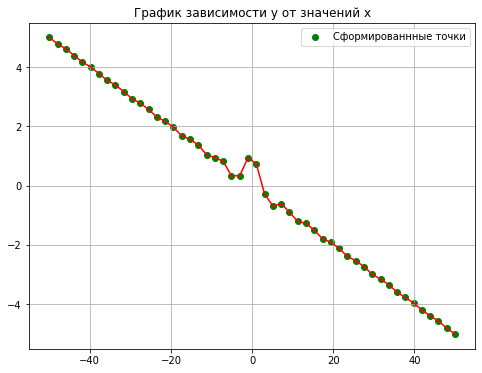

In [336]:
x, y, dataloader = form(50, True)

Создадим датасет.

## Класс генератора.

In [337]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))

            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка  
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )
        self.double()
        
    def forward(self, z):
        num = self.model(z)
        # print(num)
        return num

## Дискриминатор

### Встроенный линейный слой



In [338]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()],
            ['sigmoid', nn.Sigmoid()],
        ])

        def block(in_feat, out_feat, normalize=False, activation='lrelu'):
            layers = [nn.Linear(in_feat, out_feat)]
            
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
                
            layers.append(self.activations[activation]) 
            
            return layers

        self.model = nn.Sequential(
            *block(2, 1024),
            *block(1024, 512),
            *block(512, 256),
            *block(256, 1, activation='sigmoid'),
        )
        
        self.double()
  
    def forward(self, x):
        validity = self.model(x)
        return validity

### Через CustomLinearLayer

In [339]:
# class CustomLinearLayer(nn.Module):
#     def __init__(self, size_in, size_out):
#         # забираем все методы
#         super().__init__()
#         # инициализируем веса
#         self.size_in, self.size_out = size_in, size_out
        
#         weights = torch.Tensor(size_out, size_in)
#         self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя
#         # если объект имеет класс параметров, то он обучаемый, т.е. через него будут прогоняться градиенты

#         # подготавливаем переменные для сдвига bias
#         bias = torch.Tensor(size_out)
#         self.bias = nn.Parameter(bias)

#         # инициализируем веса и смещения (байесы) близкими к нулю значениями
#         # в данном примере если поставить -0,005 и 0,005, обучается дольше и хуже
#         nn.init.uniform_(self.weights, -0.5, 0.5) 
#         nn.init.uniform_(self.bias, -0.5, 0.5)  

#     def forward(self, x):
#         # По формуле линейного слоя, нам нужно умножить наши данные 
#         # на транспонированные веса и добавить смещение
#         w_times_x = torch.mm(x, self.weights.t())
#         return torch.add(w_times_x, self.bias) 

In [340]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.model = nn.Sequential(
#             CustomLinearLayer(2, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             CustomLinearLayer(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             CustomLinearLayer(256, 1),
#             nn.Sigmoid()
#         )
  

#     def forward(self, img):
#         img_flat = img.reshape(img.size(0), -1)
#         validity = self.model(img_flat)
#         return validity

## Обучение

In [341]:
# n_epochs = 100  # количество эпох
lr = 0.0001  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

batch_size = 128
latent_dim = 200  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 5  # количество итераций для отображения процесса обучения

In [342]:
def all_zero():
  generator = Generator().to(device)
  discriminator = Discriminator().to(device)

  # Для каждой нейронки свой оптимизатор
  optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
    )
  optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
  )

  # Но вот функция ошибки у нас будет одна общая
  adversarial_loss = torch.nn.BCELoss()

  return generator, discriminator, optimizer_G, optimizer_D, adversarial_loss

In [343]:
generator, discriminator, optimizer_G, optimizer_D, adversarial_loss = all_zero()

### Определим функцию для тренировки.

In [344]:
def train(n_epochs=20, sample_interval=10, visual1=True, visual2=True):
  sample_interval = sample_interval
  
  d_loss_history = []
  g_loss_history = []
  gen_fake = []
  ep = []

  for epoch in range(n_epochs):
      for i, (x_val, y_val) in enumerate(dataloader):
       
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.DoubleTensor(len(x_val), 1).fill_(1.0).to(device)
        fake = torch.DoubleTensor(len(x_val), 1).fill_(0.0).to(device)

        real_xy = torch.stack((x_val.to(device), y_val.to(device)), -1)
        # print(real_xy)

        # Генерация шума
        z = torch.DoubleTensor(np.random.uniform(-1, 1, (len(x_val), latent_dim))).to(device)
             
        # Генерируем данные Генератором на основе шума        
        gen_xy = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_xy)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_xy)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.DoubleTensor(np.random.uniform(-1, 1, (len(x_val), latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_xy = generator(z)

        if epoch == n_epochs-1:
          gen_fake.append(gen_xy.detach())

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_xy)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(dataloader) + i
    
        if batches_done == 0 or batches_done % sample_interval == 0:
            ep.append(batches_done + 1)
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                # sample_image(gen_imgs)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 

                # display.display(plt.gcf())
                # plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

      # if epoch == 0 or (epoch+1) % sample_interval == 0:
      #   ep.append(epoch + 1)
      #   with torch.no_grad():
      #     plt.clf()

      #     display.clear_output(wait=False)

      #     print(f"[Epoch {epoch}/{n_epochs}]",
      #     # [Batch {i}/{len(dataloader)}]",
      #     end='|')
      #     print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]')

      #     d_loss = d_loss.cpu().detach()
      #     g_loss = g_loss.cpu().detach()
          
      #     d_loss_history.append(d_loss)
      #     g_loss_history.append(g_loss)

  if visual1 == True:
    # [ep.append(s*sample_interval) for i in range(10)]
    plt.figure(figsize=(8, 6))
    plt.title('График зависимости ошибок')
    plt.grid()
    
    plt.plot(ep, np.array(d_loss_history), label='D loss', color = 'red', alpha=0.5)
    plt.scatter(ep, np.array(d_loss_history), color = 'red')
    plt.plot(ep, np.array(g_loss_history), label='G loss', color = 'green', alpha=0.5)
    plt.scatter(ep, np.array(g_loss_history), color = 'green')
    plt.legend()
  
  if visual2 == True:
    x_fake = []
    y_fake = []

    for el in gen_fake:
      for i in el:
        x_fake.append(i[0].item())
        y_fake.append(i[1].item())

    plt.figure(figsize=(8, 6))
    plt.title('Сгенерированные точки и график реальной зависимости')
    plt.scatter(x_fake,  y_fake)
    plt.plot(x, y, c='y', label='Реальная зависимость')
    plt.legend()

    plt.grid()

### Обучим модель

In [345]:
x, y, dataloader = form(100, False)
generator, discriminator, optimizer_G, optimizer_D, adversarial_loss = all_zero()

[Epoch 19/20] [Batch 0/1]|[D loss: 0.2759028504753089] [G loss: 1.2295949999259872]


<Figure size 432x288 with 0 Axes>

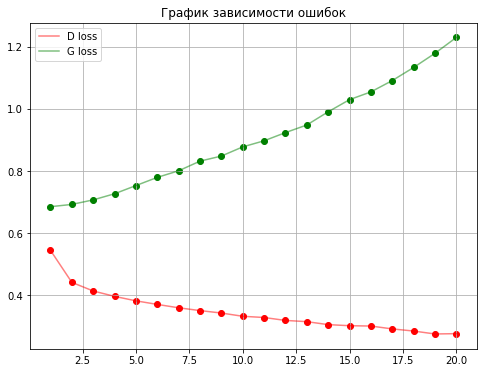

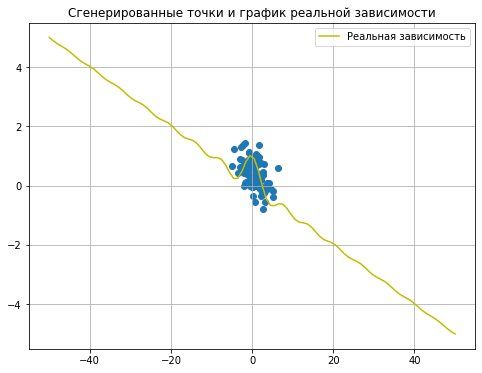

In [346]:
train(n_epochs=20, sample_interval=1)

Для малого количества точек требуется большее количество эпох обучения.

[Epoch 90/100] [Batch 0/1]|[D loss: 0.5404338820742283] [G loss: 1.2480297722504003]


<Figure size 432x288 with 0 Axes>

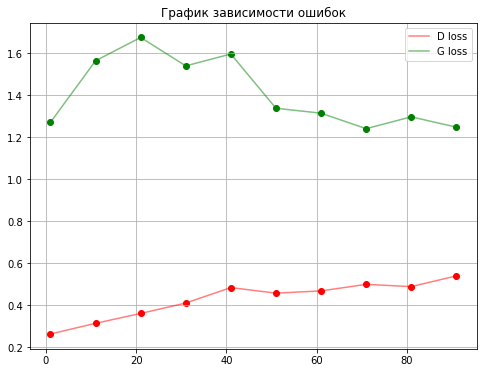

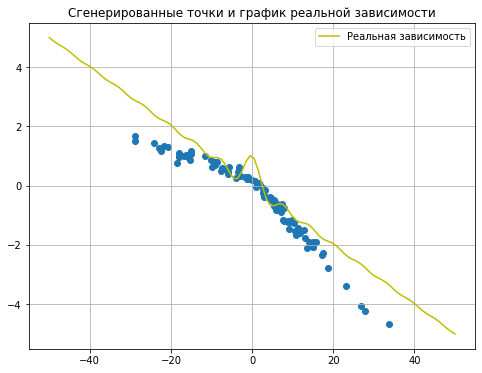

In [347]:
train(100)

Увеличим количество точек = 1000

In [348]:
x, y, dataloader = form(1000, False)
generator, discriminator, optimizer_G, optimizer_D, adversarial_loss = all_zero()

[Epoch 18/20] [Batch 6/8]|[D loss: 0.5631449408728595] [G loss: 1.0067391420382323]


<Figure size 432x288 with 0 Axes>

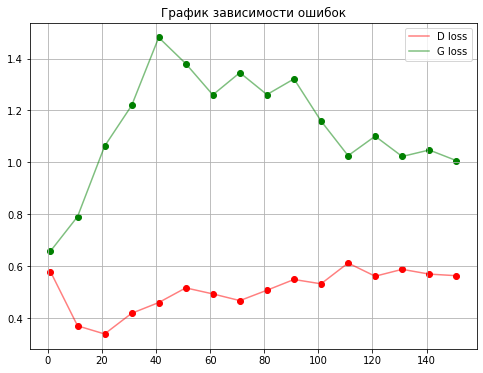

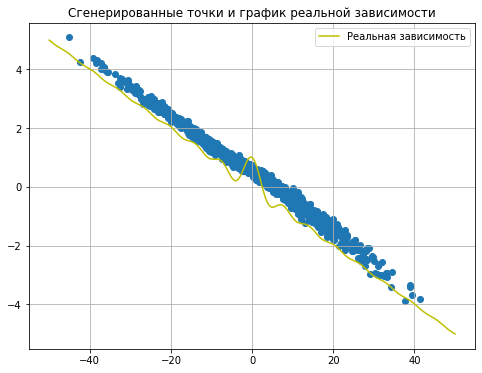

In [349]:
%time

train(sample_interval=10)

[Epoch 48/50] [Batch 6/8]|[D loss: 0.6809476769044734] [G loss: 0.6931325849852723]


<Figure size 432x288 with 0 Axes>

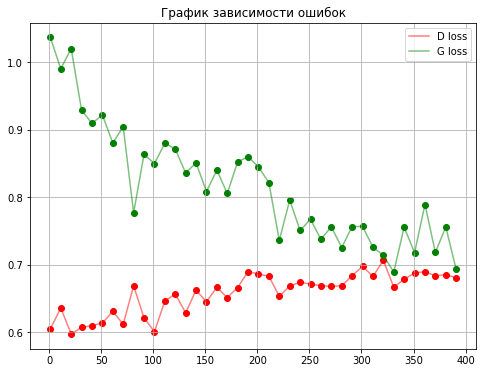

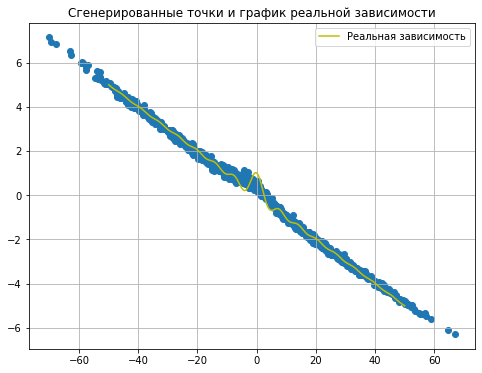

In [350]:
train(50, sample_interval=10)

Видно, что при большем количестве точек 20 эпох уже формирует хотя бы похожее на необходимое распределение 

Увеличим количество точек.

[Epoch 19/20] [Batch 137/157]|[D loss: 0.6870518645583032] [G loss: 0.7702744900648759]


<Figure size 432x288 with 0 Axes>

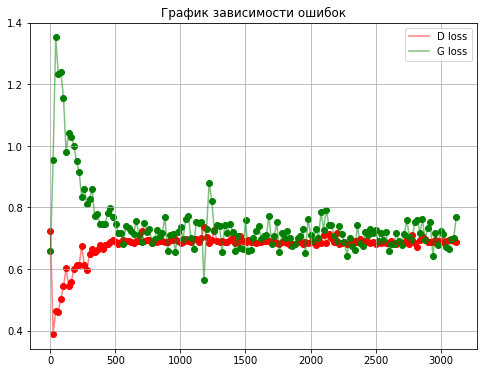

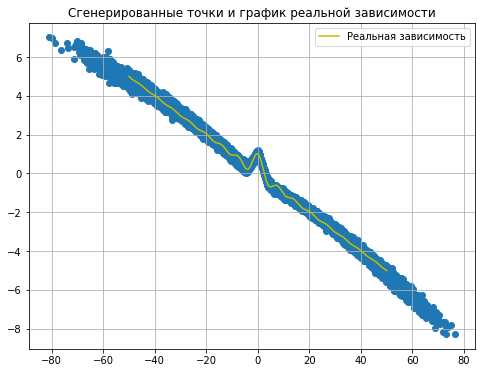

In [351]:
%time

x, y, dataloader = form(20000, False)
generator, discriminator, optimizer_G, optimizer_D, adversarial_loss = all_zero()
train(20, sample_interval=20)

Для 20000 исходных точек ошибки генератора и дискриминатора достаточно быстро сходятся. Количество эпох можно было уменьшить.